In [1]:
import torch
import os
import jaxrl_m.envs
import gym
%precision %.3f

'%.3f'

In [2]:
def load_reward_model(ckpt):
    with open(os.path.join(ckpt, "best_model.pt"), "rb") as f:
        reward_model = torch.load(f)
    return reward_model

ckpt = "logs3/sort-easy-v0/VAEClassifier/sort_final_reward_results/s42"
vae_model = load_reward_model(ckpt)
ckpt_mlp = "logs/sort-easy-fixed-v0/MLP/sort_final_reward_results/s42"
mlp_model = load_reward_model(ckpt_mlp)
env = gym.make("sort-easy-v0")

No module named 'flow'
No module named 'carla'
pybullet build time: Nov 28 2023 23:51:11
2024-04-24 11:20:26.200429: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/max/anaconda3/envs/offline/lib/python3.8/site-packages/transforms3d/quaternions.py:26: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  _MAX_FLOAT = np.maximum_sctype(np.float)
/home/max/anaconda3/envs/offline/lib/python3.8/site-packages/tensorflow_addons/utils/ensure_tf_install.py:48: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  min_version = LooseVersion(MIN_TF_VERSION)
/home/max/anaconda3/envs/offl

text argument:dependencies/ravens/ravens/environments/assets
int args: [Loaded EGL 1.5 after reload.
GL_VENDOR=NVIDIA Corporation
GL_RENDERER=NVIDIA GeForce RTX 3090 Ti/PCIe/SSE2
GL_VERSION=3.3.0 NVIDIA 525.105.17
GL_SHADING_LANGUAGE_VERSION=3.30 NVIDIA via Cg compiler
Version = 3.3.0 NVIDIA 525.105.17
Vendor = NVIDIA Corporation
Renderer = NVIDIA GeForce RTX 3090 Ti/PCIe/SSE2
EGL renderering enabled.


load datafile: 100%|██████████| 8/8 [00:00<00:00, 291.27it/s]


In [3]:
import numpy as np
from pref_learn.models.utils import get_datasets, Annealer, EarlyStopper


def sample_comparison_states(observations, size):
    indices = np.random.choice(observations.shape[0], size, replace=False)
    return observations[indices]


dataset = env.get_dataset()
observations = dataset["observations"]
comp_obs = sample_comparison_states(observations, 10000)
pref_dataset_path = "pref_datasets/sort-easy-v0/relabelled_queries_num5000_q1_s16"
observation_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
batch_size = 64
set_size = 16
(
    train_loader,
    test_loader,
    train_dataset,
    eval_dataset,
    len_set,
    len_query,
    obs_dim,
) = get_datasets(
    pref_dataset_path,
    observation_dim,
    action_dim,
    batch_size,
    set_size,
)

load datafile: 100%|██████████| 8/8 [00:00<00:00, 307.26it/s]


In [4]:
import numpy as np
from pref_learn.models.utils import get_posterior


def get_rewards(obs, z, comp_obs):
    rewards = []
    reward_model = vae_model
    z = torch.from_numpy(z).float()[None]
    obs = torch.from_numpy(obs).float().to(next(reward_model.parameters()).device)
    batch_z = (
        z.repeat(obs.shape[0], 1).float().to(next(reward_model.parameters()).device)
    )
    if "Classifier" not in ckpt:
        input_obs = torch.cat([obs, batch_z], dim=-1)
        rewards = reward_model.get_reward(input_obs)
    else:
        comp_obs = torch.from_numpy(comp_obs).float().to(next(reward_model.parameters()).device)
        batch_size = len(comp_obs) // 10
        for i in range(10):
            batch_comp = comp_obs[i * batch_size : (i + 1) * batch_size]
            batch_rewards = reward_model.decode(obs, batch_comp, batch_z)
            rewards.append(batch_rewards)
        rewards = torch.stack(rewards, dim=0)
        rewards = rewards.mean(dim=0)
        rewards = torch.exp(rewards)
    
    mlp_rewards = mlp_model.get_reward(obs)
    return rewards.detach().cpu().numpy(), mlp_rewards.detach().cpu().numpy()


def plot_rewards(rewards, mode):
    import matplotlib.pyplot as plt

    plt.plot(rewards)
    plt.title(mode)
    plt.show()


def generate_trajectory(env, oracle, mode, comp_obs, dataset):
    env.set_mode(mode)
    reward_model = vae_model
    latent = get_posterior(env, reward_model, dataset, mode, 1)[0]
    latent = reward_model.biased_latents[mode, 0]
    observation = env.reset()
    oracle.reset()
    done = False
    observations = []
    dense_rewards = []
    while not done:
        # observation = np.concatenate((observation, latent))
        observations.append(observation)
        action = oracle.act(observation, {})
        observation, r, done, info = env.step_oracle(action)
        dense_rewards.append(info["dense_reward"])
        #if r > 0.99:
            #observations.append(observation)
            #action = oracle.act(observation, {})
            #observation, r, done, info = env.step_oracle(action)
            #dense_rewards.append(info["dense_reward"])
            #break
    observations = np.stack(observations)
    rewards, mlp_rewards = get_rewards(observations, latent, comp_obs)
    dense_rewards = np.array(dense_rewards)
    #plot_rewards(rewards, mode)
    return rewards, dense_rewards, mlp_rewards

In [5]:
task = env.unwrapped.task
oracle = task.oracle(env.unwrapped.env, steps_per_seg=3)

In [6]:
mode=0
r0_train = []
r0_eval = []
for i in range(10):
    r0_eval.append(generate_trajectory(env, oracle, mode, comp_obs, eval_dataset))
    r0_train.append(generate_trajectory(env, oracle, mode, comp_obs, train_dataset))

ven = NVIDIA Corporation
ven = NVIDIA Corporation


In [7]:
mode=1
r1_train = []
r1_eval = []
for i in range(10):
    r1_eval.append(generate_trajectory(env, oracle, mode, comp_obs, eval_dataset))
    r1_train.append(generate_trajectory(env, oracle, mode, comp_obs, train_dataset))

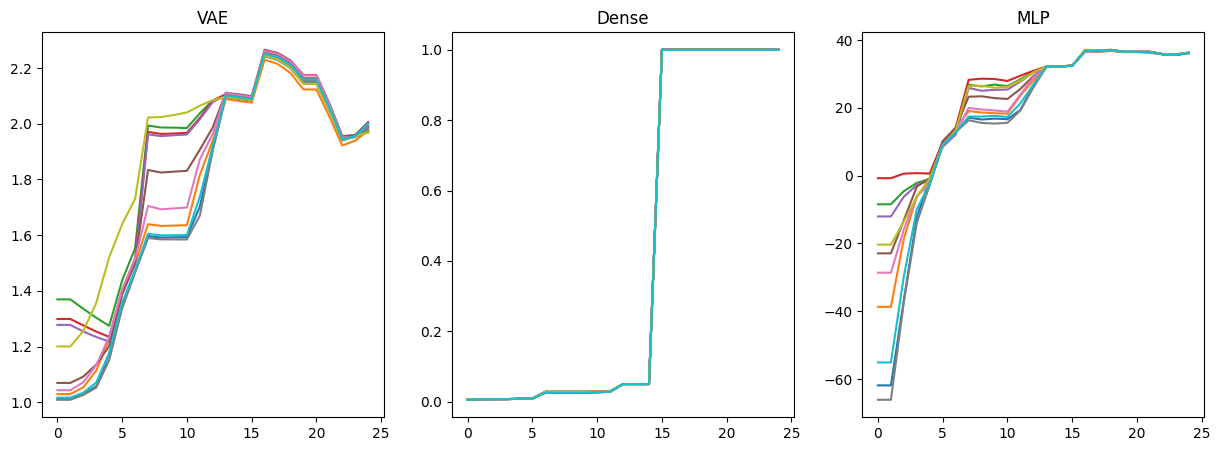

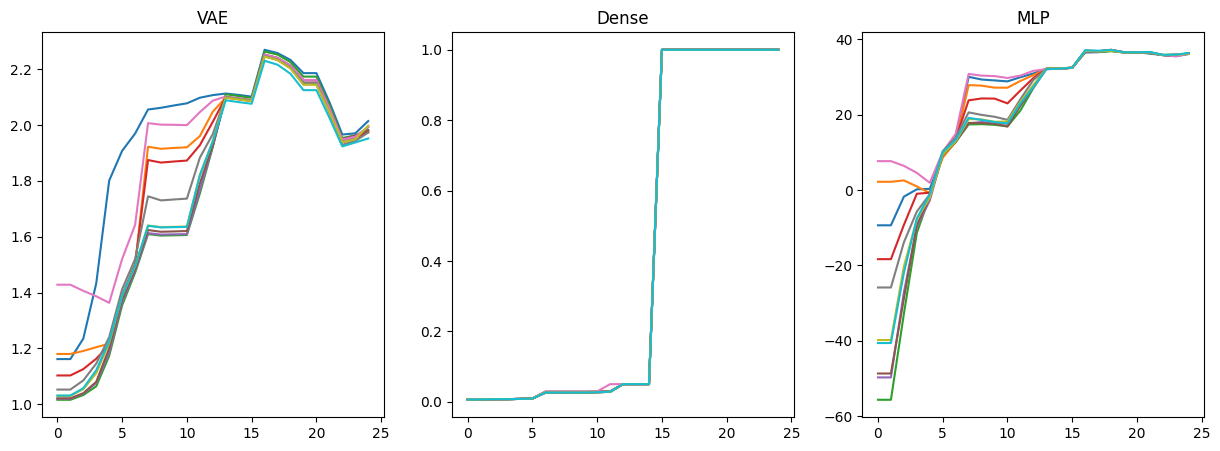

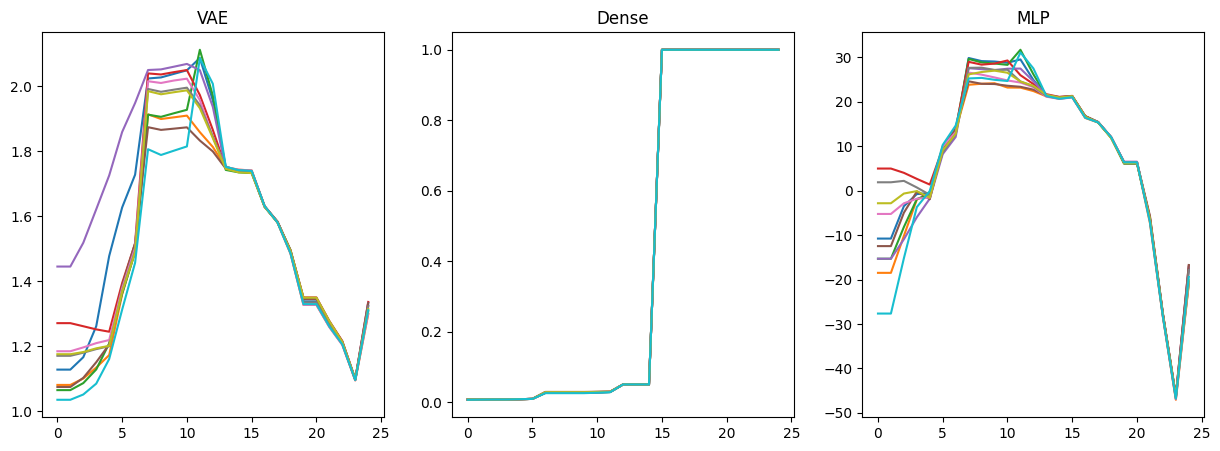

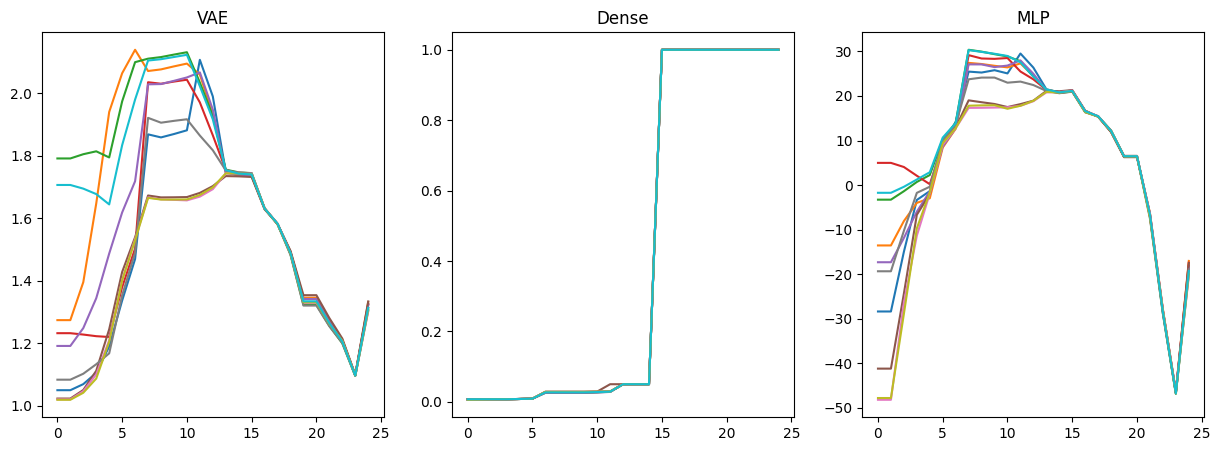

: 

In [8]:
def plot_rewards(rewards, title):
    import matplotlib.pyplot as plt
    fig, axs = plt.subplots(1,3, figsize=(15,5))
    axs = axs.flatten()
    for r in rewards:
        axs[0].plot(r[0])
        axs[0].set_title("VAE")
        axs[1].plot(r[1])
        axs[1].set_title("Dense")
        axs[2].plot(r[2])
        axs[2].set_title("MLP")
    #plt.title(title)
    plt.show()

plot_rewards(r0_train, "r0_train")
plot_rewards(r0_eval, "r0_eval")
plot_rewards(r1_train, "r1_train")
plot_rewards(r1_eval, "r1_eval")